# Advanced Lane Findig

In [130]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Helper functions

In [198]:
def read_test_image(filename):  
    return mpimg.imread(os.path.join('test_images', filename))
                       
def save_output_image(image, filename):  
    mpimg.imsave(os.path.join('output_images', filename), image)

def show_before_and_after(before_image, after_image, before_title, after_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    
    ax1.axis('off')
    if len(before_image.shape) == 3:
        ax1.imshow(before_image)
    else:
        ax1.imshow(before_image, cmap='gray')
    
    ax1.set_title(before_title, fontsize=20)
        
    ax2.axis('off')
    if len(after_image.shape) == 3:
        ax2.imshow(after_image)
    else:
        ax2.imshow(after_image, cmap='gray')
    
    ax2.set_title(after_title, fontsize=20)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibration

For technical reasons, every camera delivers images with some distortions. These distortions are systematic errors that are the same for every image taken with the same camera. Thus, the distortion in each single image can be corrected, if  the deviation between the image supplied by the camera and the correct image without distortion is known.

To determine this difference, some pictures of a known chessboard pattern from different perspectives are made with the camera. For each of these images, the crossing points can be determined using the `cv2.findChessboardCorners()` function.

With the obtained crossing points and the ideal crossing points (known from the chessboard pattern), the `cv2.calibrateCamera()` function can be used to calculate the calibration coefficients for this camera.

Once you know the calibration coefficients of a camera, any image taken with this camera can be corrected using the `cv2.undistort()` function.

Unable to find appropriate number of corners on camera_cal\calibration1.jpg
Unable to find appropriate number of corners on camera_cal\calibration4.jpg
Unable to find appropriate number of corners on camera_cal\calibration5.jpg


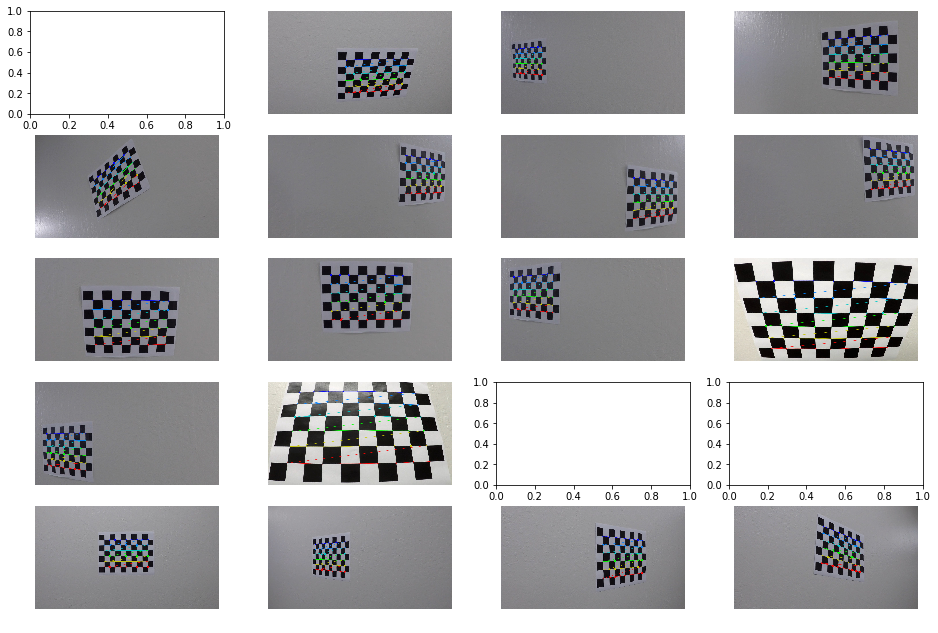

In [199]:
def camera_calibration(images, grid_size, image_size):
    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1, 2)

    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    axs = axs.ravel()

    for i, filename in enumerate(images):
        image = mpimg.imread(filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            axs[i].axis('off')
            axs[i].imshow(image)
        else:
            print("Unable to find appropriate number of corners on {0}".format(filename))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

images = glob.glob('camera_cal/calibration*.jpg')
image = mpimg.imread(images[0]) # read first calibration image to obtain the camera's image size, needed for calibration

grid_size = (9, 6) # corner points of the chessboard calibration images 
mtx, dist = camera_calibration(images, grid_size, image.shape[1::-1])

The following example shows image `calibration1.jpg` before and after the distortion correction.

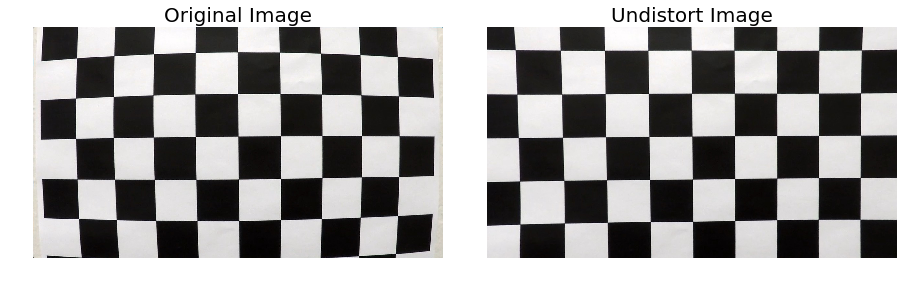

In [200]:
original = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(original, mtx, dist, None, mtx)
show_before_and_after(original, undist, before_title="Original Image", after_title = "Undistort Image")

## Image Pipeline

### Example Image

The image pipeline will be demonstrated with the sample image `test5.jpg`

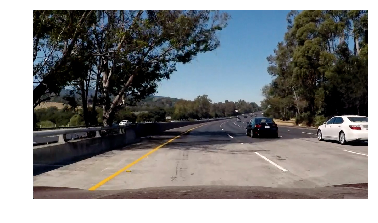

In [201]:
test_image = read_test_image('test5.jpg')
plt.axis('off')
plt.imshow(test_image)

### Step 1: Undistort Image

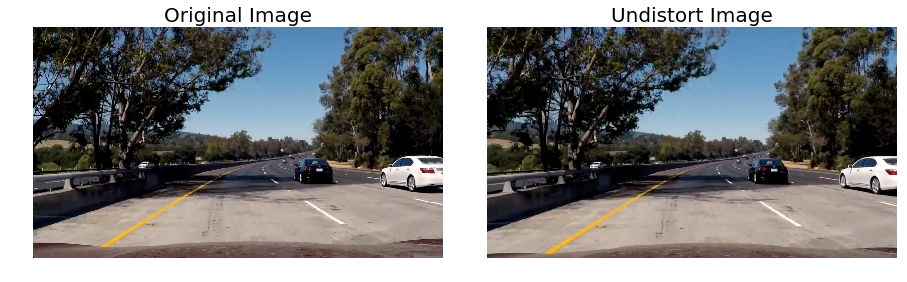

In [203]:
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
show_before_and_after(test_image, undist, before_title="Original Image", after_title = "Undistort Image")
save_output_image(undist, 'undistort.jpg')

### Step 2: Create Binary Image for Line Detection

In [204]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

In [205]:
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:, :, 2]
    L = hls[:, :, 1]

    light_mask = np.zeros_like(L)
    light_mask[(S >= 6) & (L >= 78)] = 1

    gradx_l = abs_sobel_threshold(L, orient='x', sobel_kernel=3, thresh=(17, 40))
    gradx_s = abs_sobel_threshold(S, orient='x', sobel_kernel=3, thresh=(7, 47))

    binary_image = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # combine binary masks
    binary_image[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    return binary_image * 255

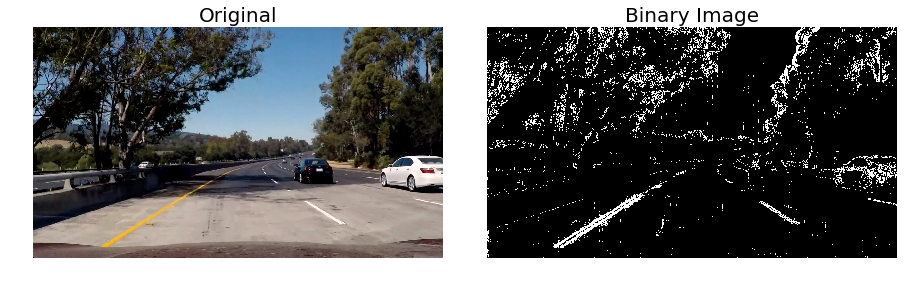

In [206]:
binary_image = get_binary_image(test_image)
show_before_and_after(test_image, binary_image, before_title="Original", after_title="Binary Image")
binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
save_output_image(binary_image, 'binary.jpg')

### Step 3: Perspective Transformation

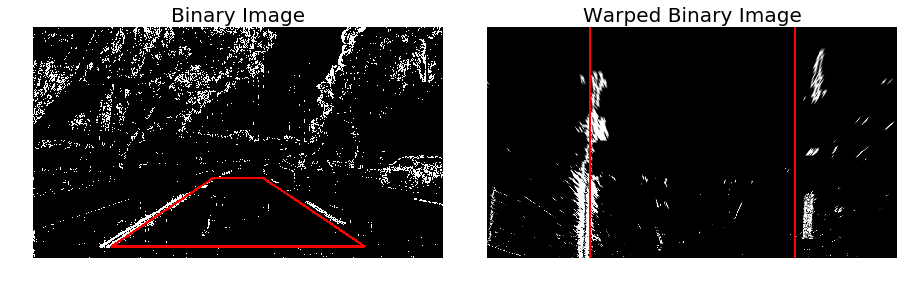

In [207]:
def get_src_points(image_size):
    height, width = image_size
    midpoint = width // 2
    bottom = height - int(height * 0.05)  # small distance from bottom
    top_distance = int(width * .06)
    bottom_distance = int(width * .31)
    points = np.float32([(midpoint - bottom_distance, bottom),
                         (midpoint - top_distance, height - int(height * .35)),
                         (midpoint + top_distance, height - int(height * .35)),
                         (midpoint + bottom_distance, bottom)])
    return points

def get_dst_points(image_size):
    height, width = image_size
    margin = width / 4
    dst = np.float32([[margin, height],
                      [margin, 0],
                      [width - margin, 0],
                      [width - margin, height]])
    return dst

def get_warp_matrices(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv
        
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

def unwarp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, invM, img_size)
    return warped

binary_image = get_binary_image(test_image) 

# get points for perspective transformation
src = get_src_points(binary_image.shape)
dst = get_dst_points(binary_image.shape)

# build warp matrix and inverse warp matrix
M, invM = get_warp_matrices(src, dst)

binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
binary_warped = warp(binary_image)

# draw roi in binary image
cv2.line(binary_image, tuple(src[0]), tuple(src[1]), (255, 0, 0), 5)
cv2.line(binary_image, tuple(src[1]), tuple(src[2]), (255, 0, 0), 5)
cv2.line(binary_image, tuple(src[2]), tuple(src[3]), (255, 0, 0), 5)
cv2.line(binary_image, tuple(src[3]), tuple(src[0]), (255, 0, 0), 5)

# draw roi in warped binary image
cv2.line(binary_warped, tuple(dst[0]), tuple(dst[1]), (255, 0, 0), 5)
cv2.line(binary_warped, tuple(dst[2]), tuple(dst[3]), (255, 0, 0), 5)

show_before_and_after(binary_image, binary_warped, before_title="Binary Image", after_title="Warped Binary Image")
save_output_image(binary_image, 'roi_binary.jpg')
save_output_image(binary_warped, 'roi_warped_binary.jpg')

### Step 4: Finding Lanes

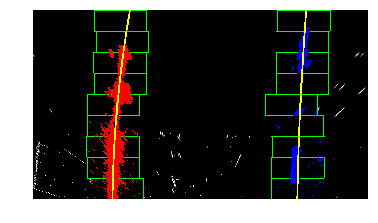

In [209]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def blind_search(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    pts = np.array(list(zip(list(left_fitx), list(ploty))), np.int32).reshape((-1, 1, 2))
    cv2.polylines(out_img, pts, True, (255, 255, 0), thickness=5)
    pts = np.array(list(zip(list(right_fitx), list(ploty))), np.int32).reshape((-1, 1, 2))
    cv2.polylines(out_img, pts, True, (255, 255, 0), thickness=5)

    return out_img, left_fit, right_fit

binary_image = get_binary_image(test_image) 
binary_warped = warp(binary_image)
out_img, left_fit, right_fit = blind_search(binary_warped)
save_output_image(out_img, 'binary_warped_sliding_window.jpg')
plt.axis('off')
plt.imshow(out_img)

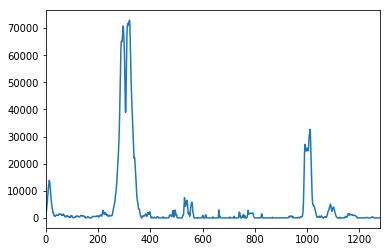

In [211]:
histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
plt.plot(histogram)
plt.xlim(0, 1280)
plt.savefig('output_images/histogram.jpg')

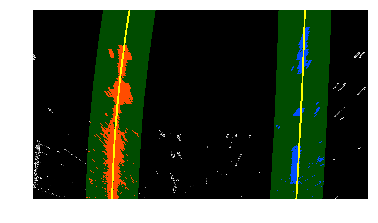

In [213]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_last_fit(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                                                    ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                                                     ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    pts = np.array(list(zip(list(left_fitx), list(ploty))), np.int32).reshape((-1, 1, 2))
    cv2.polylines(result, pts, True, (255, 255, 0), thickness=5)
    pts = np.array(list(zip(list(right_fitx), list(ploty))), np.int32).reshape((-1, 1, 2))
    cv2.polylines(result, pts, True, (255, 255, 0), thickness=5)

    return result, leftx, lefty, rightx, righty

out_img, leftx, lefty, rightx, righty = search_around_last_fit(binary_warped)
save_output_image(out_img, 'binary_warped_search_around_poly.jpg')
plt.axis('off')
plt.imshow(out_img)

### Step 5: Draw Lane

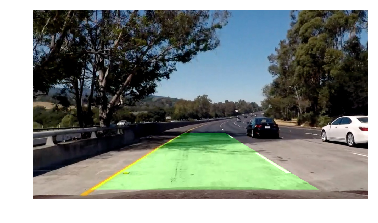

In [214]:
# Calculate polynomial fit based on detected pixels
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
rigth_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

# fill area between lanes
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rigth_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
lanes_img = np.zeros_like(undist).astype(np.uint8)
cv2.fillPoly(lanes_img, np.int_([pts]), color=(0, 255, 0))

unwarped_lanes_img = unwarp(lanes_img)
output_img = cv2.addWeighted(undist, 1, unwarped_lanes_img, 0.3, 0)
save_output_image(output_img, 'lane.jpg')
plt.axis('off')
plt.imshow(output_img)

### Step 6: Calculate Position and Radius of Curvature:

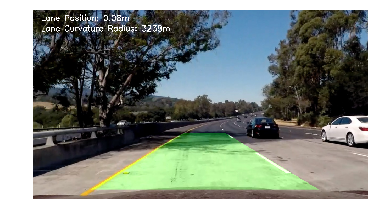

In [216]:
def get_x_at_y(line_fit, line_y):
        poly = np.poly1d(line_fit)
        return poly(line_y)
    
def get_curve_radius_and_distance_from_center(left_x, left_y, right_x, right_y, image_shape):
    ym_per_pix = 3 / 88  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 630  # meters per pixel in x dimension
        
    left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)

    left_radius_m = ((1 + (2 * left_fit_cr[0] * np.max(left_y) + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    right_radius_m = ((1 + (2 * right_fit_cr[0] * np.max(left_y) + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    # Calculate curve radius from left curve radius and right curve radius
    curve_radius_m = int((left_radius_m + right_radius_m) / 2)

    # Calculate bottom points for each lane
    left_fitx_bottom_m = get_x_at_y(left_fit_cr, image_shape[0] * ym_per_pix)
    right_fitx_bottom_m = get_x_at_y(right_fit_cr, image_shape[0] * ym_per_pix)

    # Calculate image center, in meters
    center_ideal_m = image_shape[1] * xm_per_pix / 2
    # Calculate actual center of the lane, in meters
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])

    # Calculate distance from center, in meters
    distance_from_center = abs(center_ideal_m - center_actual_m)

    return curve_radius_m, distance_from_center

curve_radius, distance_from_center = get_curve_radius_and_distance_from_center(leftx, lefty, rightx, righty, undist.shape)

lane_position = "Lane Position: {:.2f}m".format(distance_from_center)
lane_curvature = "Lane Curvature Radius: {:d}m".format(int(round(curve_radius)))

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(output_img, lane_position, (30, 40), font, 1, (255, 255, 255), 2)
cv2.putText(output_img, lane_curvature, (30, 80), font, 1, (255, 255, 255), 2)
save_output_image(output_img, 'final_image.jpg')
plt.axis('off')
plt.imshow(output_img)